In [1]:
import bayesnet_alt as bn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)

### Pachinko Allocation Model (PAM)

This is a semi-constrained version of the PAM -- not as constrained as the 3-layer or 4-layer PAM, since it allows an arbitrary number of layers ("$N$-layer PAM").  However, it does not yet allow an arbitrary DAG structure.

In [3]:
def make_dag(layers):
    g = nx.DiGraph()
    g.add_node(0)
    num_nodes = 1
    num_nodes_prev = 0
    for i, layer_size in enumerate(layers):
        if i == 0:
            for b in range(layer_size):
                g.add_edge(0, 1+b)
        else:
            prev_layer_size = layers[i - 1]
            for a in range(prev_layer_size):
                for b in range(layer_size):
                    g.add_edge(num_nodes_prev+a, num_nodes+b)
        num_nodes_prev = num_nodes
        num_nodes += layer_size
    g.graph["root"] = 0
    return g

In [4]:
def make_tree(branching_factors):
    g = nx.DiGraph()
    g.add_node(0)
    num_nodes = 1
    nodes_prev_layer = [0]
    for i, factor in enumerate(branching_factors):
        nodes_current_layer = []
        for n in nodes_prev_layer:
            for c in range(factor):
                g.add_edge(n, num_nodes)
                nodes_current_layer.append(num_nodes)
                num_nodes += 1
        nodes_prev_layer = nodes_current_layer
    g.graph["root"] = 0
    return g

In [5]:
# Define a directed acyclic graph of topics, with exactly one source (the root), and with all leaves at the same depth (?)
#g = make_dag([3,9])
g = make_tree([3,3])

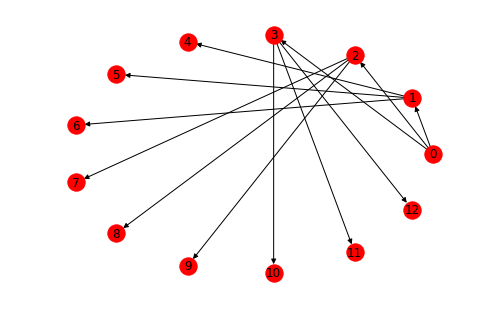

In [6]:
nx.draw_circular(g, with_labels=True)

In [7]:
def all_paths(g, start=None, prefix=()):
    if start is None:
        start = g.graph["root"]
    assert nx.algorithms.is_directed_acyclic_graph(g)
    yield prefix
    node = convert_path_to_node(g, path = prefix)
    for c in nx.neighbors(g, node):
        for p in all_paths(g, start = c, prefix = prefix + (c,)):
            yield p

def depth(g):
    depths = set()
    for p in all_paths(g):
        if num_children(g, convert_path_to_node(g, p)) == 0:
            depths.add(len(p))
    assert len(depths) == 1
    return list(depths)[0]

def convert_path_to_node(g, path):
    if len(path) == 0:
        return g.graph["root"]
    else:
        return path[-1]

def num_children(g, node):
    return len(list(nx.neighbors(g, node)))

In [8]:
depth(g)

2

In [9]:
m = bn.Model()
for node in g.nodes:
    nc = num_children(g, node)
    if nc == 0:
        m.add_random_variable(("alpha", node), bn.ConstantPlaceholder(shape=(bn.IndexSet("vocab"),)))
    else:
        m.add_random_variable(("alpha", node), bn.ConstantPlaceholder(shape=(nc,)))
documents_by_word_slot = bn.SymbolicMapping("word_slots", "documents", "documents_by_word_slot")

with m.loop_over("d", "documents") as d:
    for node in g.nodes:
        if num_children(g, node) > 0:
            m.add_random_variable(("theta", node, d), bn.Dirichlet(("alpha", node)))

# Bottom layer is shared across corpus
for node in g.nodes:
    if num_children(g, node) == 0:
        m.add_random_variable(("shared_theta", node), bn.Dirichlet(("alpha", node)))

def node_id(word, depth_index):
    if depth_index == 0:
        return g.graph["root"]
    else:
        return ("current_node", word, depth_index)

with m.loop_over("w", "word_slots") as w:
    m.add_random_variable(("current_doc", w), bn.Deterministic(documents_by_word_slot, args=[w]))
    for i in range(depth(g)):
        m.add_random_variable(("current_theta", w, i), bn.DeterministicLookup("theta", indices=[node_id(w, i), ("current_doc", w)]))
        m.add_random_variable(("child_index", w, i), bn.Categorical(("current_theta", w, i)))
        m.add_random_variable(("current_node", w, i+1),
            bn.Deterministic(lambda x, y: sorted(list(nx.neighbors(g, x)))[y], args=[node_id(w, i), ("child_index", w, i)]))
    m.add_random_variable(("current_theta", w, depth(g)), bn.DeterministicLookup("shared_theta", indices=[node_id(w, depth(g))]))
    m.add_random_variable(("t", w), bn.Categorical(("current_theta", w, depth(g))))  # <-- observed data

In [10]:
m.signatures

{'alpha': Signature(for_loop_variables=(None, None)),
 'child_index': Signature(for_loop_variables=(None, for w in word_slots, None)),
 'current_doc': Signature(for_loop_variables=(None, for w in word_slots)),
 'current_node': Signature(for_loop_variables=(None, for w in word_slots, None)),
 'current_theta': Signature(for_loop_variables=(None, for w in word_slots, None)),
 'shared_theta': Signature(for_loop_variables=(None, None)),
 't': Signature(for_loop_variables=(None, for w in word_slots)),
 'theta': Signature(for_loop_variables=(None, None, for d in documents))}

In [11]:
m.distribs

{('alpha', 0): ConstantPlaceholder(shape=(3,)),
 ('alpha', 1): ConstantPlaceholder(shape=(3,)),
 ('alpha', 2): ConstantPlaceholder(shape=(3,)),
 ('alpha', 3): ConstantPlaceholder(shape=(3,)),
 ('alpha', 4): ConstantPlaceholder(shape=(IndexSet(name='vocab'),)),
 ('alpha', 5): ConstantPlaceholder(shape=(IndexSet(name='vocab'),)),
 ('alpha', 6): ConstantPlaceholder(shape=(IndexSet(name='vocab'),)),
 ('alpha', 7): ConstantPlaceholder(shape=(IndexSet(name='vocab'),)),
 ('alpha', 8): ConstantPlaceholder(shape=(IndexSet(name='vocab'),)),
 ('alpha', 9): ConstantPlaceholder(shape=(IndexSet(name='vocab'),)),
 ('alpha', 10): ConstantPlaceholder(shape=(IndexSet(name='vocab'),)),
 ('alpha', 11): ConstantPlaceholder(shape=(IndexSet(name='vocab'),)),
 ('alpha', 12): ConstantPlaceholder(shape=(IndexSet(name='vocab'),)),
 ('child_index',
  for w in word_slots,
  0): Categorical(probs=('current_theta', for w in word_slots, 0)),
 ('child_index',
  for w in word_slots,
  1): Categorical(probs=('current_th

In [12]:
vocab_size = 8
vocab = ['w{:02}'.format(i) for i in range(vocab_size)]

num_documents = 5000
words_per_doc = 20

def docs_by_word_impl(w):
    return w // words_per_doc

In [13]:
placeholder_vars = [x for x in m.distribs.keys() if x[0] == "alpha"]
placeholders = dict()
for v in placeholder_vars:
    shape = m.distribs[v].shape
    for i in range(len(shape)):
        if isinstance(shape[i], bn.IndexSet) and shape[i].name == "vocab":
            shape = shape[:i] + (vocab_size,) + shape[i+1:]
    placeholders[v] = np.ones(shape)

In [14]:
%%time
data, sampler = m.generate_data(
    output_vars = [("t", bn.IndexSet("word_slots"))],
    placeholders = placeholders,
    sets = {
        "documents": np.arange(num_documents),
        "word_slots": np.arange(words_per_doc * num_documents),
        "vocab": np.arange(vocab_size),
        "nodes": list(g.nodes),
        "depths": np.arange(depth(g)),
    },
    mappings = {
        "documents_by_word_slot": docs_by_word_impl,
    },
    return_sampler = True,
)

CPU times: user 24.6 s, sys: 438 ms, total: 25 s
Wall time: 25.1 s


In [15]:
dg = depth(g)
topics_available = sorted([k[1] for k in sampler.cache.keys() if k[0] == "shared_theta"])
num_topics = len(topics_available)
topics_available

[4, 5, 6, 7, 8, 9, 10, 11, 12]

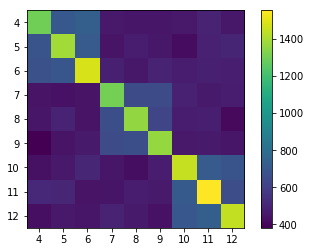

In [16]:
counts = np.zeros((num_topics, num_topics), dtype='int')
for i in range(num_documents):
    for j in range(words_per_doc // 2):
        node0 = sampler.cache["current_node", words_per_doc*i + 2*j + 0, dg]
        node1 = sampler.cache["current_node", words_per_doc*i + 2*j + 1, dg]
        combo = (
            topics_available.index(node0),
            topics_available.index(node1),
        )
        counts[combo] += 1
fig, ax = plt.subplots()
ax.imshow(counts);
ax.set_xticks(np.arange(num_topics))
ax.set_yticks(np.arange(num_topics))
ax.set_xticklabels(topics_available)
ax.set_yticklabels(topics_available)
fig.colorbar(ax.get_images()[0]);